# World Bank

автор: Маликов Виталий

### Цель проекта

Разработать автоматизированный pipeline для сбора, обработки и анализа данных Всемирного банка (получение ключевых показателей через API). Визуализировать ключевые метрики и проверить гипотезу о связи экономического роста и экологического воздействия. Результатом будут интерактивный дашборд и отчет (Jupyter), который можно будет легко воспроизвести при наличии скрипта pipeline

### Стек технологий
•	Язык программирования: Python 3.8+
•	Основные библиотеки: requests, pandas, sqlalchemy, seaborn, plotly
•	Для дашборда: streamlit, datalens, tableau (на выбор)
•	Для документации / отчета: Jupyter Notebook, Jupyter Lab
•	Система контроля версий: GitHub / GitLab

### Алгоритм работы:

Этап 1: Получение метаданных и списка показателей

Этап 2: Pipeline – загрузка данных

Этап 3: Pipeline – очистка и предобработка данных

Этап 4: Анализ и визуализация (Jupyter)

Этап 5: Создание аналитической панели (Datalens)

Этап 6: Документирование и упаковка (GitHub)

In [1]:
import psycopg2
from dotenv import load_dotenv
import os
import sqlite3
from sqlalchemy import create_engine
import sqlalchemy
import matplotlib.pyplot as plt
import seaborn as sns

import requests
import pandas as pd
from typing import List, Optional
from sqlalchemy import inspect

# Load environment variables from .env
load_dotenv("main.env")  

# Fetch variables
USER = os.getenv("user")
PASSWORD = os.getenv("password")
HOST = os.getenv("host")
PORT = os.getenv("port")
DBNAME = os.getenv("dbname")

# Connect to the database
try:
    connection = psycopg2.connect(
        user=USER,
        password=PASSWORD,
        host=HOST,
        port=PORT,
        dbname=DBNAME,
        sslmode="require"
    )
    print("Connection successful!")
    
    # Create a cursor to execute SQL queries
    cursor = connection.cursor()
    
    # Example query
    cursor.execute("SELECT NOW();")
    result = cursor.fetchone()
    print("Current Time:", result)

    # Close the cursor and connection
    cursor.close()
    connection.close()
    print("Connection closed.")

except Exception as e:
    print(f"Failed to connect: {e}")

Connection successful!
Current Time: (datetime.datetime(2025, 12, 7, 6, 58, 18, 802139, tzinfo=datetime.timezone.utc),)
Connection closed.


In [2]:
url = "https://api.worldbank.org/v2/country?format=json&per_page=500"

#Получаем данные о странах с обработкой ошибок
try:
    # Отправляем GET запрос к World Bank API
    response = requests.get(url)
    response.raise_for_status()  # Поднимает ошибку (4** или 5**) если статус некорректный

    # Парсим ответ от API в вид JSON
    data = response.json()

# Обрабатываем ошибки, если такие возникнут
except requests.exceptions.RequestException as e:
    print(f"An error occurred while fetching data: {e}")
except (IndexError, KeyError, ValueError) as e:
    print(f"An error occurred while processing the data: {e}")

In [3]:
data[1][0]['id'], data[1][0]['name'], data[1][0]['incomeLevel'], data[1][0]['incomeLevel']['value']

('ABW',
 'Aruba',
 {'id': 'HIC', 'iso2code': 'XD', 'value': 'High income'},
 'High income')

In [4]:
# Создаем датафрейм
countries = data[1]
df = pd.DataFrame(countries)
df.head()

,id,iso2Code,name,region,adminregion,incomeLevel,lendingType,capitalCity,longitude,latitude
0,ABW,AW,Aruba,"{'id': 'LCN', 'iso2code': 'ZJ', 'value': 'Lati...","{'id': '', 'iso2code': '', 'value': ''}","{'id': 'HIC', 'iso2code': 'XD', 'value': 'High...","{'id': 'LNX', 'iso2code': 'XX', 'value': 'Not ...",Oranjestad,-70.0167,12.5167
1,AFE,ZH,Africa Eastern and Southern,"{'id': 'NA', 'iso2code': 'NA', 'value': 'Aggre...","{'id': '', 'iso2code': '', 'value': ''}","{'id': 'NA', 'iso2code': 'NA', 'value': 'Aggre...","{'id': '', 'iso2code': '', 'value': 'Aggregates'}",,,
2,AFG,AF,Afghanistan,"{'id': 'MEA', 'iso2code': 'ZQ', 'value': 'Midd...","{'id': 'MNA', 'iso2code': 'XQ', 'value': 'Midd...","{'id': 'LIC', 'iso2code': 'XM', 'value': 'Low ...","{'id': 'IDX', 'iso2code': 'XI', 'value': 'IDA'}",Kabul,69.1761,34.5228
3,AFR,A9,Africa,"{'id': 'NA', 'iso2code': 'NA', 'value': 'Aggre...","{'id': '', 'iso2code': '', 'value': ''}","{'id': 'NA', 'iso2code': 'NA', 'value': 'Aggre...","{'id': '', 'iso2code': '', 'value': 'Aggregates'}",,,
4,AFW,ZI,Africa Western and Central,"{'id': 'NA', 'iso2code': 'NA', 'value': 'Aggre...","{'id': '', 'iso2code': '', 'value': ''}","{'id': 'NA', 'iso2code': 'NA', 'value': 'Aggre...","{'id': '', 'iso2code': '', 'value': 'Aggregates'}",,,


In [5]:
# Вытащим идентификатор региона из столбца регион: для этого вытаскиваем значения по ключу id
df['region_id'] = df.region.apply(lambda x: x.get('id', None))

In [6]:
# Вытащим информацию о регионах, административных регионах, уровню дохода и типу лендинга - вытаскиваем значения по ключу value
for col in ['region', 'adminregion', 'incomeLevel', 'lendingType']:
    df[col + '_value'] = df[col].apply(lambda cell: cell.get('value', None))

In [7]:
# Оставляем только нужные для анализа столбцы
df = df[['id', 'iso2Code', 'name', 'capitalCity', 'longitude', 'latitude',
         'region_id', 'region_value', 'adminregion_value', 'incomeLevel_value',
         'lendingType_value']]

In [8]:
df.head()

,id,iso2Code,name,capitalCity,longitude,latitude,region_id,region_value,adminregion_value,incomeLevel_value,lendingType_value
0,ABW,AW,Aruba,Oranjestad,-70.0167,12.5167,LCN,Latin America & Caribbean,,High income,Not classified
1,AFE,ZH,Africa Eastern and Southern,,,,NA,Aggregates,,Aggregates,Aggregates
2,AFG,AF,Afghanistan,Kabul,69.1761,34.5228,MEA,"Middle East, North Africa, Afghanistan & Pakistan","Middle East, North Africa, Afghanistan & Pakis...",Low income,IDA
3,AFR,A9,Africa,,,,NA,Aggregates,,Aggregates,Aggregates
4,AFW,ZI,Africa Western and Central,,,,NA,Aggregates,,Aggregates,Aggregates


In [9]:
# Приводим названия столбцов к snake_case
new_cols = ['id', 'iso2_code', 'name', 'capital', 'longitude', 'latitude', 'region_id', 'region', 'admin_region', 'income_level', 'lending_type']

df.columns = new_cols

In [10]:
# Меняем расположение столбцов
df = df[['id', 'iso2_code', 'name', 'region_id', 'region', 'admin_region', 'income_level', 'capital', 'longitude', 'latitude', 'lending_type']]

In [11]:
df.head()

,id,iso2_code,name,region_id,region,admin_region,income_level,capital,longitude,latitude,lending_type
0,ABW,AW,Aruba,LCN,Latin America & Caribbean,,High income,Oranjestad,-70.0167,12.5167,Not classified
1,AFE,ZH,Africa Eastern and Southern,NA,Aggregates,,Aggregates,,,,Aggregates
2,AFG,AF,Afghanistan,MEA,"Middle East, North Africa, Afghanistan & Pakistan","Middle East, North Africa, Afghanistan & Pakis...",Low income,Kabul,69.1761,34.5228,IDA
3,AFR,A9,Africa,NA,Aggregates,,Aggregates,,,,Aggregates
4,AFW,ZI,Africa Western and Central,NA,Aggregates,,Aggregates,,,,Aggregates


In [12]:
df_only_countries = df[df['lending_type'] != 'Aggregates']
country_name = list(df_only_countries['id'])
#country_name

In [13]:
# Получение данных о показателях с АПИ всемирного банка
def fetch_worldbank_data(indicators: List[str],
                         countries: List[str],
                         start_year: int,
                         end_year: int,
                         language: str = 'en') -> pd.DataFrame:

    '''
    Получает данные показателей из API Всемирного банка.

    Args:
        indicators: Список кодов показателей (например, ['EN.GHG.CO2.IC.MT.CE.AR5'])
        countries: Список кодов стран в формате ISO 2 или ISO 3 (например, ['RU', 'US'])
        start_year: Год начала периода
        end_year: Год окончания периода
        language: Язык данных ('en', 'ru' и т.д.)

    Returns:
        pandas.DataFrame с данными показателей
    '''

    base_url = "https://api.worldbank.org/v2" # endpoint API - адрес по которому мы обращаемся за данными

    # преобразовываем страны в строку с разделителем точка с запятой (для запроса данных)
    countries_str = ';'.join(countries)

    # список для хранения данных о показателях
    all_data = []

    try:
        for indicator in indicators:
            # Формируем URL для запроса
            url = f"{base_url}/{language}/country/{countries_str}/indicator/{indicator}"
            params = {
                'format': 'json',
                'date': f"{start_year}:{end_year}",
                'per_page': 10000  # Большое значение для получения всех данных
            }

            # Выполняем запрос к API
            response = requests.get(url, params=params)
            response.raise_for_status()

            data = response.json()

            # API возвращает массив, где первый элемент - метаданные, второй - данные
            if len(data) > 1 and isinstance(data[1], list):
                for item in data[1]:
                    if item.get('value') is not None:
                        all_data.append({
                            'country': item['country']['value'],
                            'country_code': item['countryiso3code'],
                            'indicator': item['indicator']['value'],
                            'indicator_code': item['indicator']['id'],
                            'year': int(item['date']),
                            'value': item['value']
                        })

        # Создаем DataFrame
        df_indicator = pd.DataFrame(all_data)

        if df_indicator.empty:
            print("Предупреждение: Не получено данных для указанных параметров")
            return df_indicator

        return df_indicator

    # Обрабатываем возможные ошибки при работе с АПИ
    except requests.exceptions.RequestException as e:
        print(f"Ошибка при запросе к API: {e}")
        return pd.DataFrame()
    except (KeyError, IndexError, ValueError) as e:
        print(f"Ошибка при обработке данных: {e}")
        return pd.DataFrame()

In [14]:
# Construct the SQLAlchemy connection string
DATABASE_URL = f"postgresql+psycopg2://{USER}:{PASSWORD}@{HOST}:{PORT}/{DBNAME}?sslmode=require"

# Create the SQLAlchemy engine
engine = sqlalchemy.create_engine(DATABASE_URL)

# Test the connection
try:
    with engine.connect() as connection:
        print("Connection successful!")
except Exception as e:
    print(f"Failed to connect: {e}")

Connection successful!


In [15]:
# Промышленные выбросы CO2 EN.GHG.CO2.IC.MT.CE.AR5
# ВВП на душу населения (текущие, $) NY.GDP.PCAP.CD
# ВВП (текущие, $) NY.GDP.MKTP.CD
# Население SP.POP.TOTL
# Городское население (процент от населения) SP.URB.TOTL.IN.ZS
# Доступ к электричеству (процент населения) EG.ELC.ACCS.ZS
# Электроэнергия, потребляемая на душу населения (кВтч) EG.USE.ELEC.KH.PC
# Государственные расходы на образование (процент от ВВП) SE.XPD.TOTL.GD.ZS
# Уровень грамотности взрослого населения (процент от населения старше 15 лет) SE.ADT.LITR.ZS

# Total protests and riots since 2018 CC.ACLD.PRTS.NO
# Starting a business: Time - Men (days) IC.REG.DURS.MA.DY
# Электроэнергия на душу населения EG.USE.ELEC.KH.PC 

WORLD_BANK_INDICATOR = ['EN.GHG.CO2.IC.MT.CE.AR5', # Промышленные выбросы
                        'NY.GDP.PCAP.CD', # ВВП на душу населения (текущие, $)
                        'SP.POP.TOTL', # Население
                        'SP.URB.TOTL.IN.ZS', # Городское население (процент от населения)
                        'EG.ELC.ACCS.ZS', # Доступ к электричеству (процент населения)
                        'EG.USE.ELEC.KH.PC', # Электроэнергия, потребляемая на душу населения (кВтч)
                        'SE.XPD.TOTL.GD.ZS', # Государственные расходы на образование (процент от ВВП)
                        'SE.ADT.LITR.ZS', # Уровень грамотности взрослого населения (процент от населения старше 15 лет)
                        'IC.REG.DURS.MA.DY', # Starting a business: Time - Men (days)
                       ]

# Создадим цикл для автоматической выгрузки данных по индикаторам для всех стран из базы ВБ 
for i in WORLD_BANK_INDICATOR:
    indicators = [i]
    print(f'Получение данных для индикатора: {i}')

    start_year = 1980
    end_year = 2025

    countries = country_name  # Россия, США, Китай 'RU', 'US', 'CN' ... (получаем список всех стран)

    df_country_indicator = fetch_worldbank_data(indicators, countries, start_year, end_year)
    df_country_indicator.to_sql(f'{i}', con=engine, if_exists='replace', index=False)
    

print(f'\nДанные за период {start_year} - {end_year} успешно собраны и залиты в БД!')
print('Едем дальше')

Получение данных для индикатора: EN.GHG.CO2.IC.MT.CE.AR5
Получение данных для индикатора: NY.GDP.PCAP.CD
Получение данных для индикатора: SP.POP.TOTL
Получение данных для индикатора: SP.URB.TOTL.IN.ZS
Получение данных для индикатора: EG.ELC.ACCS.ZS
Получение данных для индикатора: EG.USE.ELEC.KH.PC
Получение данных для индикатора: SE.XPD.TOTL.GD.ZS
Получение данных для индикатора: SE.ADT.LITR.ZS
Получение данных для индикатора: IC.REG.DURS.MA.DY

Данные за период 1980 - 2025 успешно собраны и залиты в БД!
Едем дальше


In [16]:
# Загружаем в БД словарь с координатами стран для создания чарта "карта" на дашборде

df_dict = pd.read_csv(r'/Users/vitaly/Desktop/Проект Страны/geo_for_datalens/all_country_borders.csv', sep=';')

df_dict.to_sql('Dictionary', con=engine, if_exists='replace', index=False)
df_dict.head()

,name_ru,name_en,coords_type,coords
0,Польша,Poland,all_country_borders_poly,"[[[55.0338306,18.366366700000015],[55.0063306,..."
1,Дания,Denmark,all_country_borders_poly,"[[[55.1476253,14.3443989],[55.4916387,14.85030..."
2,Германия,Germany,all_country_borders_poly,"[[[50.5973695,6.2461937],[50.5978889,6.248485]..."
3,Швеция,Sweden,all_country_borders_poly,"[[[57.3348282,17.6814016],[57.5714347,17.73773..."
4,Фарерские острова,Faroe Islands,all_country_borders_poly,"[[[62.5958399,-6.569739],[62.5845442,-6.416468..."


## Забираем данные из БД, смотрим корреляцию, проверяем гопотезы 

- Гипотеза: существует ли корреляция между уровнем экономического развития страны (ВВП на душу населения - 'NY.GDP.PCAP.CD') и уровнем человеческого развития (Электроэнергия, потребляемая на душу населения (кВтч) - 'EG.USE.ELEC.KH.PC', Государственные расходы на образование (процент от ВВП) - 'SE.XPD.TOTL.GD.ZS', Уровень грамотности взрослого населения (процент от населения старше 15 лет) - 'SE.ADT.LITR.ZS'), и как эта зависимость менялась с течением времени для разных групп стран (по уровню дохода / континенту и так далее)?

In [17]:
# Получаем названия всех таблиц из БД 
inspector = inspect(engine)
table_names = inspector.get_table_names()

print('Таблицы в БД:')
print(table_names)

Таблицы в БД:
['test', 'EN.GHG.CO2.IC.MT.CE.AR5', 'NY.GDP.PCAP.CD', 'SP.POP.TOTL', 'SP.URB.TOTL.IN.ZS', 'EG.ELC.ACCS.ZS', 'EG.USE.ELEC.KH.PC', 'SE.XPD.TOTL.GD.ZS', 'SE.ADT.LITR.ZS', 'IC.REG.DURS.MA.DY', 'Dictionary']


In [18]:
# Читаем таблицу и сохраняем в датафрейм
df_GDP = pd.read_sql('NY.GDP.PCAP.CD', con=engine).rename(columns={'value': 'gdp_per_capita'})
df_ELEC = pd.read_sql('EG.USE.ELEC.KH.PC', con=engine).rename(columns={'value': 'electricity_use'})
df_EXP_GD = pd.read_sql('SE.XPD.TOTL.GD.ZS', con=engine).rename(columns={'value': 'education_expenditure'})
df_ADT_LITR = pd.read_sql('SE.ADT.LITR.ZS', con=engine).rename(columns={'value': 'literacy_rate'})

# Чтобы проверить корреляцию присоединим другие таблицы
df_merged = df_GDP.merge(df_ELEC, on=['country', 'year'], how='left')
df_merged = df_merged[['country', 'year', 'country_code_x', 'gdp_per_capita', 'electricity_use']]
df_merged = df_merged.rename(columns={'country_code_x': 'country_code'})

df_merged = df_merged.merge(df_EXP_GD, on=['country', 'year'], how='left')
df_merged = df_merged[['country', 'year', 'country_code_x', 'gdp_per_capita', 'electricity_use', 'education_expenditure']]
df_merged = df_merged.rename(columns={'country_code_x': 'country_code'})

df_merged = df_merged.merge(df_ADT_LITR, on=['country', 'year'], how='left')
df_merged = df_merged[['country', 'year', 'country_code_x', 'gdp_per_capita', 'electricity_use', 'education_expenditure', 'literacy_rate']]
df_merged = df_merged.rename(columns={'country_code_x': 'country_code'})

In [19]:
# Посмотрим корреляцию
corr_columns = ['gdp_per_capita', 'electricity_use', 'education_expenditure', 'literacy_rate']
corr_matrix = df_merged[corr_columns].corr()
corr_matrix

,gdp_per_capita,electricity_use,education_expenditure,literacy_rate
gdp_per_capita,1.000000,0.709488,0.038351,0.338585
electricity_use,0.709488,1.000000,0.299437,0.386360
education_expenditure,0.038351,0.299437,1.000000,0.189405
literacy_rate,0.338585,0.386360,0.189405,1.000000


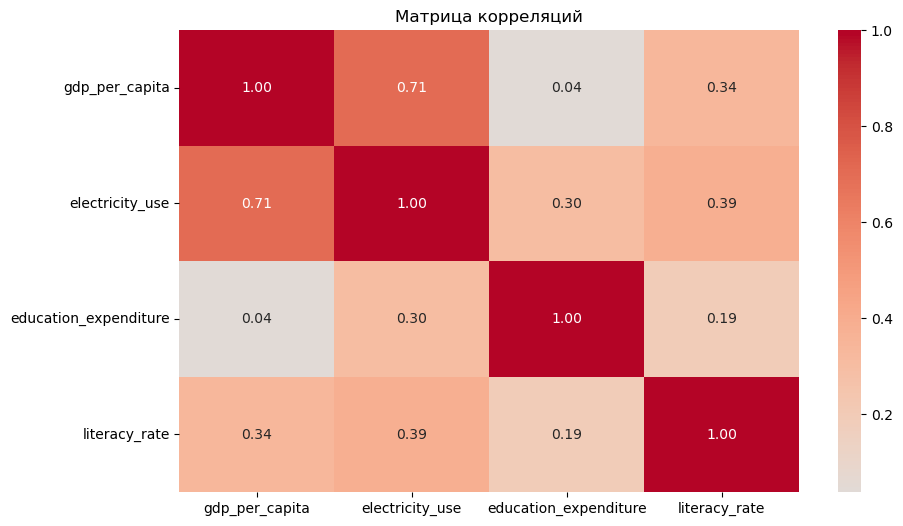

In [20]:
# Визуализация матрицы корреляций
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Матрица корреляций')
plt.show()

#### Наблюдение:
- Видно сильную корреляцию между ВВП и потреблением электричества
- Умеренная корреляция есть между ВВП и уровнем образованности населения
- Пактически нет связи между ВВП и расходами государства на образование

- Умеренная корреляция между потреблением электричества и уровнем образованности населения
- Умеренная корреляция между потреблением электричества и расходами государства на образование

## Вывод:
- Гипотеза о том, что существует связь между показателем ВВП и уровнем человеческого развития подтвердилась